In [1]:
import fnmatch, os, sys
# Change this path to be wherever your `cage_data` directory is
sys.path.append('/media/storage/behavior_data/millerlab/cage_data-master')

In [2]:
import cage_data
import pickle
import numpy as np
from scipy import stats

### Set filenames to load, and print labels

In [4]:
dir_path = '/media/storage/behavior_data/millerlab/continuous/'

cage_data_filenames = ['20201020_Pop_Cage_001.pkl',
                       '20201020_Pop_Cage_002.pkl',
                       '20201020_Pop_Cage_003.pkl',
                       '20201020_Pop_Cage_004.pkl',
                       '20201020_Pop_Cage_005.pkl',
                       '20201020_Pop_Cage_006.pkl',
                       '20201020_Pop_Cage_007.pkl']

In [5]:
# Print the begavior classes in each video
# Video 5 has a 'grooming' that is not in other datasets, don't use 5

print('Behavior classes in training set:')
for file in cage_data_filenames:
    with open (dir_path+file, 'rb' ) as fp:
        temp = pickle.load(fp)
    print(sorted(set(temp.behave_tags['tag'])))

Behavior classes in training set:
['crawling', 'high picking treats', 'low picking treats', 'pg']
['crawling', 'high picking treats', 'low picking treats', 'pg']
['crawling', 'high picking treats', 'low picking treats', 'pg', 'sitting still']
['crawling', 'high picking treats', 'low picking treats', 'pg', 'sitting still']
['crawling', 'grooming', 'high picking treats', 'low picking treats', 'pg']
['crawling', 'high picking treats', 'low picking treats', 'pg', 'sitting still']
['crawling', 'high picking treats', 'low picking treats', 'pg', 'sitting still']


### Autocorrelation

(15, 18004)
(15, 18004)


<IPython.core.display.Javascript object>


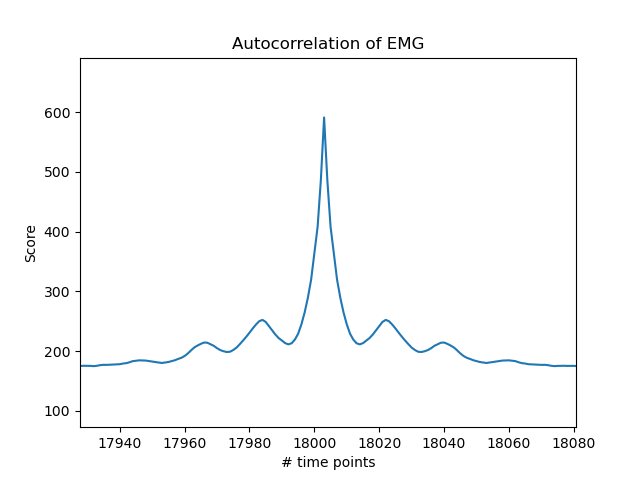

Text(0.5, 1.0, 'Autocorrelation of EMG')

In [11]:
# YOU DON'T NEED TO RUN THIS - See where autocorrelation drops off in order to pick a sequence length 
import matplotlib.pyplot as plt
%matplotlib notebook

with open (dir_path+'20201020_Pop_Cage_007.pkl', 'rb' ) as fp:
    my_cage_data = pickle.load(fp)

filtered_EMG = my_cage_data.binned['filtered_EMG']
muscles = np.array(filtered_EMG)[:10000]
print(muscles.shape)
muscles = muscles[:10000]
print(muscles.shape)

auto_corrs = 0
muscles = muscles - np.mean(muscles, axis=0)

for i, muscle in enumerate(muscles):
    auto_corrs += (np.correlate(muscle, muscle, mode="full")) / len(muscle)
auto_corrs /= 16
plt.plot(auto_corrs)
plt.xlabel('# time points')
plt.ylabel('Score')
plt.title('Autocorrelation of EMG')

### Convert to VRAE format

In [6]:
def convert_to_vrae_format(my_cage_data, SEQ_LEN, bhvs):
    
    # Sort all behavior segments by their start timestep - NOT EVERY EMG HAS A BEHAVIOR ASSIGNED TO IT 
    behavior_segs = my_cage_data.get_all_data_segment()
    behavior_segs = sorted(behavior_segs, key=lambda k: k['timeframe'][0])
    
    # To get the rectified, filtered and downsampled EMGs
    filtered_EMG = my_cage_data.binned['filtered_EMG']
    filtered_EMG = np.array(filtered_EMG).T
    
    
    # To get the time frame of the binned data
    timeframe = my_cage_data.binned['timeframe']
    
    # Create list of tuples (time_stamp, behavior)
    emg_lbls = []
    for i, time in enumerate(timeframe):
        curr_time_tup = None
        for seg in behavior_segs:
            if time >= seg['timeframe'][0] and time <= seg['timeframe'][-1]:
                curr_emg_tup = np.concatenate((bhvs[seg['label']], filtered_EMG[i]))
                break
            else:
                curr_emg_tup = np.concatenate((bhvs['no_behavior'], filtered_EMG[i]))
        emg_lbls.append(curr_emg_tup)
        
    # Create array where timestamp is first dimension and (channels + behavior class) is second
    emg_lbls = np.array(emg_lbls)
    
    # Chop off last last frames so we can evenly divide
    rem = emg_lbls.shape[0] % SEQ_LEN
    if rem != 0:
        emg_lbls = emg_lbls[:-rem, :]
        
    # Reshape, 16 is 15channel+1label
    emg_lbls = emg_lbls.reshape(-1, SEQ_LEN, 16)
    
    # Add overlap. and find the most represented class in each sequence
    out = []
    overlap_idx = int(SEQ_LEN * 0.5)
    for i, emg_seq in enumerate(emg_lbls):
        # Append indexed sequence with its class
        seq_class = stats.mode(emg_seq[:,0])[0]
        flat_emg = emg_seq[:,1:].reshape(-1)
        out.append(np.concatenate((seq_class, flat_emg)))

        # Add 50% time overlap array to output
        if i < len(emg_lbls) - 1:
            overlap = np.concatenate((emg_seq[overlap_idx:, :], emg_lbls[i][:overlap_idx, :]), axis=0)
            overlap_class = stats.mode(overlap[:,0])[0]
            flat_overlap = overlap[:,1:].reshape(-1)
            out.append(np.concatenate((overlap_class, flat_overlap)))
    
    out = np.array(out)
    
    return out

In [7]:
seq_len = 10

# Create behavior class dict for mapping - these are all the currently labeled behaviors they gave us
bhvs = {'crawling': np.array([0]),
        'high picking treats': np.array([1]),
        'low picking treats': np.array([2]),
        'pg': np.array([3]),
        'sitting still': np.array([4]),
        'grooming': np.array([5]),
        'no_behavior': np.array([-1])}

# Create inverse mapping for debugging
# inv_bhvs = {v: k for k, v in bhvs.items()}
inv_bhvs = {int(v): k for k, v in bhvs.items()}

In [8]:
# Saving single files
for file in cage_data_filenames:
    print(file)
    with open ( dir_path+file, 'rb' ) as fh:
        my_cage_data = pickle.load(fh)
    converted_temp = convert_to_vrae_format(my_cage_data, seq_len, bhvs)
    print(converted_temp.shape)
    np.savetxt('/home/roton2/ruize/timeseries-clustering-vae/data/EMG/'+file[:-4], converted_temp, delimiter=',')

20201020_Pop_Cage_001.pkl
(3599, 151)
20201020_Pop_Cage_002.pkl
(3599, 151)
20201020_Pop_Cage_003.pkl
(3599, 151)
20201020_Pop_Cage_004.pkl
(3601, 151)
20201020_Pop_Cage_005.pkl
(3599, 151)
20201020_Pop_Cage_006.pkl
(3599, 151)
20201020_Pop_Cage_007.pkl
(3599, 151)


In [86]:
# Saving concatenated files
data_converted = []
for file in cage_data_filenames:
    print(file)
    with open ( dir_path+file, 'rb' ) as fh:
        my_cage_data = pickle.load(fh)
    converted_temp = convert_to_vrae_format(my_cage_data, seq_len, bhvs)
    print(converted_temp.shape)
    data_converted.append(converted_temp)
print(len(data_converted))
all_data = np.vstack(data_converted)
print(train_data.shape)
np.savetxt('/home/roton2/ruize/timeseries-clustering-vae/data/EMG/aaaaa', all_data, delimiter=',')

20201020_Pop_Cage_001.pkl
(3599, 151)
20201020_Pop_Cage_002.pkl
(3599, 151)
20201020_Pop_Cage_003.pkl
(3599, 151)
20201020_Pop_Cage_004.pkl
(3601, 151)
20201020_Pop_Cage_005.pkl
(3599, 151)
20201020_Pop_Cage_006.pkl
(3599, 151)
20201020_Pop_Cage_007.pkl
(3599, 151)
7
(17997, 151)
